In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
%matplotlib inline
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
import math
from astropy.table import Table

In [2]:
cd ../

/Users/lenatreiber/Desktop/Yale


In [3]:
import hardnessratios as h

Investigating HR using Swift data of LXP 69.5 was more complicated than I expected, probably thanks to the much lower total count rates. Last time I worked on Swift HRs, there were 186,000 events to work with. Here, there are only a total of 725 as far as I understand it. So I approached the binning in a few different ways: importing the evt file and separating by obsid; using the online product's PCHR qdp file, which separates the soft and hard rates, I think by obsid as well. And then I experimented with binning in time and by some number of events.

It may be helpful to do HR vs. time and HR vs. count rate analysis on the NICER data instead, but hopefully there's something meaningful to be seen here as well. 

# Import Evt File

In [4]:
#file path and name
file = 'LXP69.5_Swift/lc/pcsourcetotal.evt'
#put evt file into astropy table
hdu_list = fits.open(file, memmap=True)
evt_data = Table(hdu_list[1].data)

hdr = fits.getheader(file)
objname = hdr['OBJECT'] 
print(objname)
print('total events:',len(evt_data))

#find MJD dates of events
mjd = h.timeconvert(evt_data['TIME'],hdr)


RXJ0529.8-6556
total events: 725


In [5]:
#add MJD-50000 to astropy table
evt_data['day']=mjd-50000

In [6]:
Table(hdu_list[2].data)
#not sure what length of 44 corresponds to

START,STOP
float64,float64
435976958.53777176,435977279.4721718
437008235.64705175,437008917.63265175
545219201.7821916,545219447.4975916
545219473.6065234,545219726.8438233
546411645.8440516,546411879.0229515
546411902.7736717,546412156.0109715
548249833.7930317,548250077.0011315
548250110.4025117,548250356.1179116
548828727.1571916,548828980.3944916


In [7]:
evt_data[:5]

TIME,X,Y,RAWX,RAWY,DETX,DETY,PHA,PI,GRADE,STATUS [16],BPFILE,SRCRAD,PUPRAD,OBSDIR,day
float64,int16,int16,int16,int16,int16,int16,int32,int32,int16,bool,str24,int32,float64,str37,float64
435976971.07427174,548,501,341,111,342,112,97,28,0,False .. False,badpixel_file_number0009,12,0.0,/swift/data/local_reproc/00033493001,6956.030500674438
435977191.7178117,541,505,342,121,343,122,1257,361,0,False .. False,badpixel_file_number0009,12,0.0,/swift/data/local_reproc/00033493001,6956.0330544191165
437008343.46095175,538,516,373,144,374,145,96,35,0,False .. False,badpixel_file_number0010,12,0.0,/swift/data/local_reproc/00033493002,6967.967681075825
437008376.0559316,547,509,374,134,375,135,727,230,1,False .. False,badpixel_file_number0010,12,0.0,/swift/data/local_reproc/00033493002,6967.968058332539
437008516.46529174,541,510,376,138,377,139,1619,472,0,False .. False,badpixel_file_number0010,12,0.0,/swift/data/local_reproc/00033493002,6967.969683440875


# Strategy 1: Separate by Obsid
- method used in past for finding HRs of Swift data
- uses hardnessratios.py

In [8]:
#find indices of change between different obs ids, as well as mean time in seconds and MJD
change,mt,mjd = h.sepobs(evt_data['OBSDIR'],evt_data['TIME'],evt_data['day'])

In [9]:
#first epoch of data
e1 = evt_data[evt_data['day']<8000]
e2 = evt_data[evt_data['day']>8000]
e2 = e2[e2['day']<8500]
e3 = evt_data[evt_data['day']>8500]

In [10]:
sh, hr, rerr, oth = h.ebin(evt_data['PI'],change,30,150,1000)
change2,mt2,mjd2 = h.sepobs(e2['OBSDIR'],e2['TIME'],e2['day'])
sh2, hr2, rerr2, oth2 = h.ebin(e2['PI'],change2,30,150,1000)
change3,mt3,mjd3 = h.sepobs(e3['OBSDIR'],e3['TIME'],e3['day'])
sh3, hr3, rerr3, oth3 = h.ebin(e3['PI'],change3,30,150,1000)

In [11]:
tot2 = np.sum(sh2,axis=1)
tot3 = np.sum(sh3,axis=1)
tot3

array([101.,  85., 145.,  79.,  26.,  18.,  20.,  18.])

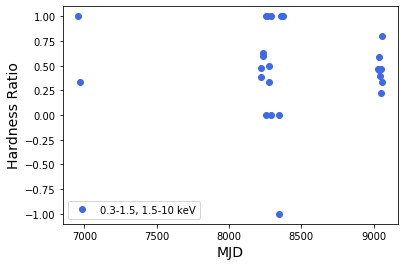

In [12]:
plt.figure(figsize=(6,4))
plt.errorbar(mjd,hr,linestyle='None',marker='o',color='royalblue',label='0.3-1.5, 1.5-10 keV')
plt.xlabel('MJD',fontsize=14)
plt.ylabel('Hardness Ratio',fontsize=14)
plt.legend()

Text(0, 0.5, 'Counts in Obsid')

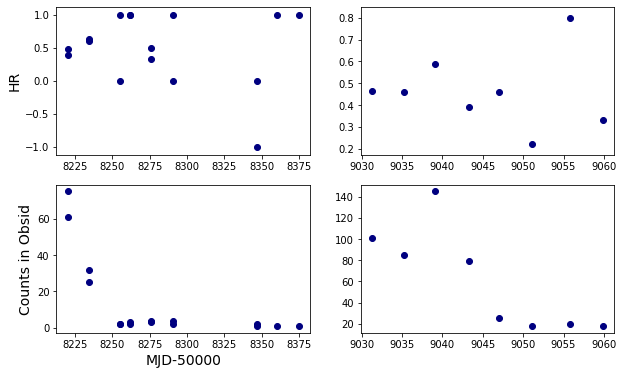

In [13]:
#total counts in obsid not a rate
fig,ax = plt.subplots(2,2,figsize=(10,6))
ax[0][0].scatter(mjd2,hr2,color='navy')
ax[1][0].scatter(mjd2,tot2,color='navy')
ax[0][1].scatter(mjd3,hr3,color='navy')
ax[1][1].scatter(mjd3,tot3,color='navy')
ax[1][0].set_xlabel('MJD-50000',fontsize=14)
ax[0][0].set_ylabel('HR',fontsize=14)
ax[1][0].set_ylabel('Counts in Obsid',fontsize=14)

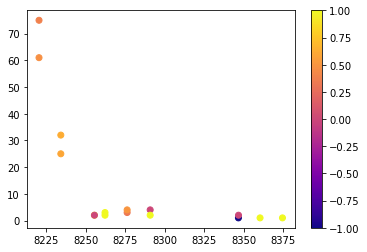

In [14]:
plt.scatter(mjd2,tot2,c=hr2,cmap='plasma')
plt.colorbar()

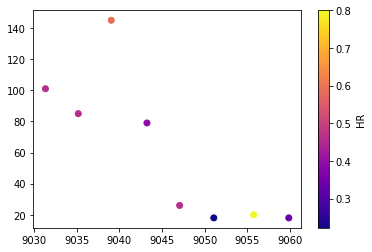

In [15]:
plt.scatter(mjd3,tot3,c=hr3,cmap='plasma')
plt.colorbar(label='HR')

# Strategy 2: Use PCHR.qdp file
- should have similar binning but could help with rate issue

In [16]:
cols=['Time','T_+ve','T_-ve','HardRate','Harderr','HardSig',
      'SoftRate','SoftErr','SoftSig','HR','HRerr','FracExp',
      'Exposure','OBSID']
pc = pd.read_csv('LXP69.5_Swift/lc/PCHR.qdp',delimiter='\s+',skiprows=2,comment='!',names=cols,engine='python')
pc.head()

,Time,T_+ve,T_-ve,HardRate,Harderr,HardSig,SoftRate,SoftErr,SoftSig,HR,HRerr,FracExp,Exposure,OBSID
0,1.970040e+02,160.467,-160.467,0.004066,0.004243,61.034611,-0.000277,0.000084,0.000000,-14.669020,-15.932969,1.000000,320.9344,::ObsID=00033493001
1,1.031655e+06,340.993,-340.993,0.003849,0.002814,97.999908,0.001706,0.001991,29.396829,2.256044,3.107081,1.000000,681.9856,::ObsID=00033493002
2,1.092425e+08,262.531,-262.531,0.249412,0.025239,1496.790552,0.098628,0.015885,523.677178,2.528823,0.481008,0.950275,498.9527,::ObsID=00094083001
3,1.104350e+08,255.083,-255.083,0.123942,0.018147,708.683084,0.028404,0.008761,138.972262,4.363489,1.489880,0.953445,486.4162,::ObsID=00094083003
4,1.122732e+08,261.162,-261.162,0.008192,0.004820,128.658634,0.002330,0.002712,23.732897,3.515443,4.584918,0.936052,488.9235,::ObsID=00094083004


In [17]:
#not sure of reason for difference of length
print(len(pc),len(hr))

25 26


(-20, 12)

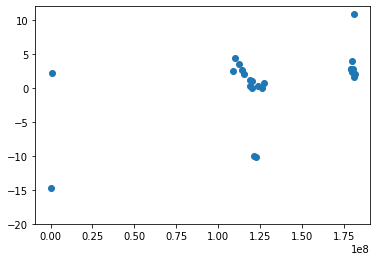

In [18]:
#remember this is the simpler HR of hard/soft
plt.scatter(pc['Time'],pc['HR'])
# plt.xlim(1e8,1.4e8)
plt.ylim(-20,12)

## see effect of using their def of HR (hard counts/soft counts)

Text(0.5, 0, 'Time (s)')

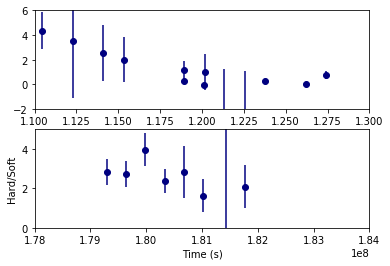

In [19]:
#same plot but zoom in on flares
#first and second outburst on top and bottom
fig,ax = plt.subplots(2,1)
ax[1].errorbar(pc['Time'],pc['HR'],yerr=pc['HRerr'],xerr=pc['T_+ve'],linestyle='none',marker='o',color='navy')
ax[1].set_xlim(1.78e8,1.84e8)
ax[1].set_ylim(0,5)

ax[0].errorbar(pc['Time'],pc['HR'],yerr=pc['HRerr'],xerr=pc['T_+ve'],linestyle='none',marker='o',color='navy')
ax[0].set_xlim(1.1e8,1.3e8)
ax[0].set_ylim(-2,6)
plt.ylabel('Hard/Soft')
plt.xlabel('Time (s)')

In [20]:
#use file to get regular hardness ratios; compare to method with evt file
har=pc['HardRate']
sof=pc['SoftRate']
pc['TotalRate']=har+sof
he=pc['Harderr']
se=pc['SoftErr']
h_ar=unumpy.uarray(har,he)
s_ar=unumpy.uarray(sof,se)
hardrat = (h_ar-s_ar)/(h_ar+s_ar)
tot=h_ar+s_ar
pc['TotErr']=np.zeros(25)
pc['HardRat']=np.zeros(25)
pc['HardRat Err']=np.zeros(25)
for r in range(len(har)):
    pc['TotErr'][r]=tot[r].s
    pc['HardRat'][r]=hardrat[r].n
    pc['HardRat Err'][r]=hardrat[r].s

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 0, 'Time (s)')

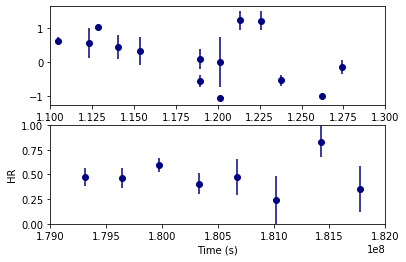

In [21]:
fig,ax = plt.subplots(2,1)
ax[1].errorbar(pc['Time'],pc['HardRat'],yerr=pc['HardRat Err'],xerr=pc['T_+ve'],linestyle='none',marker='o',color='navy')
ax[1].set_xlim(1.79e8,1.82e8)
ax[1].set_ylim(0,1)

ax[0].errorbar(pc['Time'],pc['HardRat'],yerr=pc['HardRat Err'],xerr=pc['T_+ve'],linestyle='none',marker='o',color='navy')
ax[0].set_xlim(1.1e8,1.3e8)
# ax[0].set_ylim(-2,6)
plt.ylabel('HR')
plt.xlabel('Time (s)')

Text(0, 0.5, 'Total Rate')

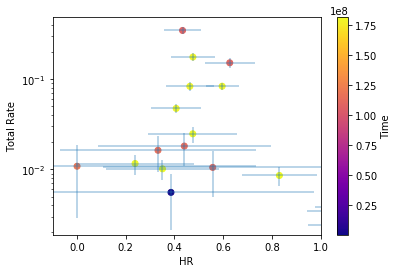

In [22]:
#similar to Reig plots
#can change x lims
plt.errorbar(pc['HardRat'],pc['TotalRate'],yerr=pc['TotErr'],xerr=pc['HardRat Err'],linestyle='none',alpha=.4)
plt.scatter(pc['HardRat'],pc['TotalRate'],c=pc['Time'],cmap='plasma')
plt.colorbar(label='Time')
plt.xlim(-.1,1)
# plt.ylim(0,1)
plt.yscale('log')
plt.xlabel('HR')
plt.ylabel('Total Rate')

Text(0, 0.5, 'Total Rate')

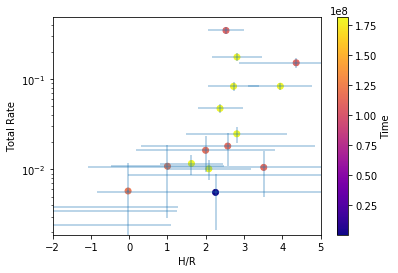

In [23]:
#using H/R, cutting out outliers near -20 and 20
plt.errorbar(pc['HR'],pc['TotalRate'],yerr=pc['TotErr'],xerr=pc['HRerr'],linestyle='none',alpha=.4)
plt.scatter(pc['HR'],pc['TotalRate'],c=pc['Time'],cmap='plasma')
plt.colorbar(label='Time')
plt.xlim(-2,5)
# plt.ylim(0,1)
plt.yscale('log')
plt.xlabel('H/R')
plt.ylabel('Total Rate')

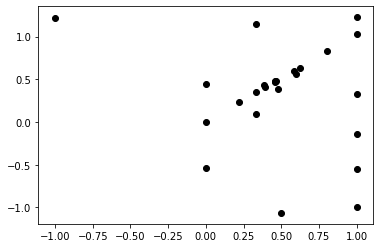

In [24]:
plt.scatter(hr[1:],pc['HardRat'],color='black') #trying to compare first and second methods

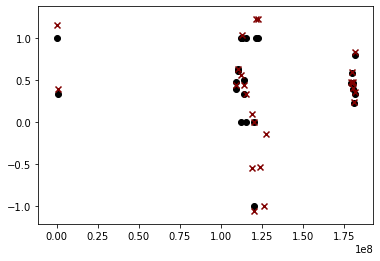

In [25]:
#same axes
plt.scatter(mt-mt[0],hr,color='black')
plt.scatter(pc['Time'],pc['HardRat'],color='maroon',marker='x')

Text(0.5, 0, 'Time')

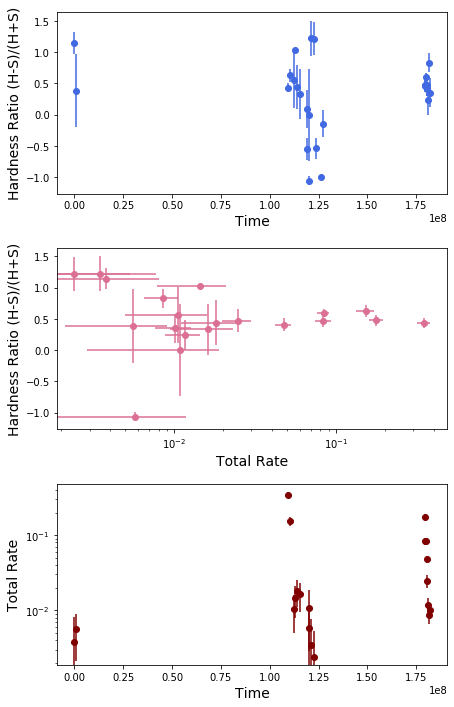

In [26]:
fig,ax=plt.subplots(3,1,figsize=(7,12))
plt.subplots_adjust(hspace=.3)
ax[0].errorbar(pc['Time'],pc['HardRat'],yerr=pc['HardRat Err'],color='royalblue',linestyle='None',marker='o')

ax[1].errorbar(pc['TotalRate'],pc['HardRat'],yerr=pc['HardRat Err'],xerr=pc['TotErr'],color='palevioletred',linestyle='None',marker='o')
ax[2].errorbar(pc['Time'],pc['TotalRate'],yerr=pc['TotErr'],color='maroon',linestyle='None',marker='o')

#ax[2].errorbar(pcr['MJD'],pcr['Rate'],yerr=pcr['Error'],color='mediumorchid',linestyle='None',marker='x',label='PC ratio')

#ax[2].legend()
#plt.setp(ax[:2], ylim=(0,8))
#plt.setp(ax, xlim=(56640,56725))
ax[0].set_ylabel('Hardness Ratio (H-S)/(H+S)',fontsize=14)
ax[1].set_ylabel('Hardness Ratio (H-S)/(H+S)',fontsize=14)
ax[2].set_ylabel('Total Rate',fontsize=14)
ax[2].set_yscale('log')
ax[0].set_xlabel('Time',fontsize=14)
ax[1].set_xlabel('Total Rate',fontsize=14)
ax[1].set_xscale('log')
ax[2].set_xlabel('Time',fontsize=14)
# ax[0].set_xlim(1.78e8,1.84e8)
# ax[2].set_xlim(1.78e8,1.84e8)
# ax[1].set_ylim(-.5,1.5)

# Strategy 3: Separate Hard and Soft Tables
- can then determine **bins in time** and count how many in soft and hard tables with ease


In [27]:
#separate tables for hard and soft events
#filtering with PI
low = 30
cutoff = 150
high = 1000
soft = evt_data[evt_data['PI']>=low]
soft = soft[soft['PI']<=cutoff]

hard = evt_data[evt_data['PI']>cutoff]
hard = hard[hard['PI']<=high]

In [28]:
len(soft)

184

In [29]:
(len(hard)-len(soft))/(len(hard)+len(soft)) 

0.4860335195530726

In [30]:
#bins in time (after will be binned by number of events)
e1s = soft[soft['day']<8000]
e1h = hard[hard['day']<8000]

e2s = soft[soft['day']>8000]
e2h = hard[hard['day']>8000]
e2s = e2s[e2s['day']<8500]
e2h = e2h[e2h['day']<8500]

e3s = soft[soft['day']>8500]
e3h = hard[hard['day']>8500]

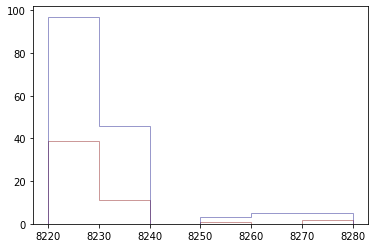

In [31]:
#binned by ten days
step2 = 10
e2sb = plt.hist(e2s['day'],bins=np.arange(8220,8290,step2),alpha=.4,histtype='step',color='maroon')
e2hb = plt.hist(e2h['day'],bins=np.arange(8220,8290,step2),alpha=.4,histtype='step',color='navy')


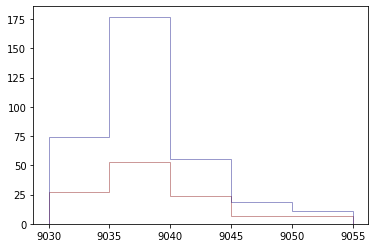

In [32]:
#binned by five days
step3 = 5
e3sb = plt.hist(e3s['day'],bins=np.arange(9030,9060,step3),alpha=.4,histtype='step',color='maroon')
e3hb = plt.hist(e3h['day'],bins=np.arange(9030,9060,step3),alpha=.4,histtype='step',color='navy')

In [33]:
#compute HRs for each bin
e2hr = (e2hb[0]-e2sb[0])/(e2hb[0]+e2sb[0])
e3hr = (e3hb[0]-e3sb[0])/(e3hb[0]+e3sb[0])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [34]:
e2t = np.arange(8220+step2/2,8290-step2/2,step2)
e2t

array([8225., 8235., 8245., 8255., 8265., 8275.])

In [35]:
e3sb[1]


array([9030, 9035, 9040, 9045, 9050, 9055])

In [36]:
e3t = np.arange(9030+step3/2,9060-step3,step3)
e3t

array([9032.5, 9037.5, 9042.5, 9047.5, 9052.5])

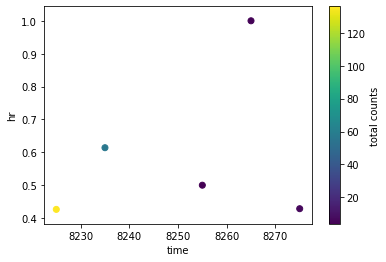

In [37]:
#hr vs time for archival outburst; notice very few counts in final bins
plt.scatter(e2t,e2hr,c=e2sb[0]+e2hb[0])
plt.xlabel('time')
plt.ylabel('hr')
plt.colorbar(label='total counts')

Text(0, 0.5, 'hr')

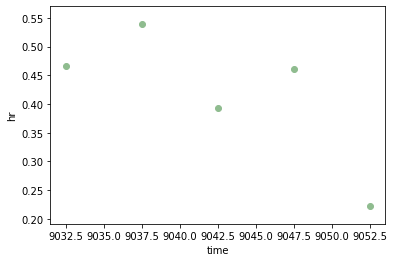

In [38]:
#hr vs. time for June outburst decay
plt.scatter(e3t,e3hr,color='darkseagreen')
plt.xlabel('time')
plt.ylabel('hr')

# Strategy 4: Even Division of Events
- so not even binning in time, could be across obsids

In [39]:
def binev(ev,n,low=30,mid=150,high=1000):
    #computes ratio for every n events
    ratios = []
    tims = []
    tab = ev[ev['PI']>=low]
    tab = tab[tab['PI']<=high]
    for i in range(len(tab)):
        hard = tab[n*i:n*(i+1)][tab[n*i:n*(i+1)]['PI']>mid]
        soft = tab[n*i:n*(i+1)][tab[n*i:n*(i+1)]['PI']<mid]
        t = np.mean(tab['TIME'][n*i:n*(i+1)])
        if len(hard) > 0 and len(soft) > 0:
            rat = (len(hard)-len(soft))/(len(hard)+len(soft))
            ratios.append(rat)
            tims.append(t)
    return ratios, tims

In [40]:
len(e2)

224

In [41]:
#can try different numbers of events
e2r, e2tim = binev(e2,50)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3332: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


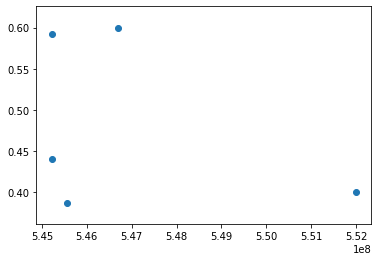

In [42]:
plt.scatter(e2tim,e2r)


In [43]:
e3r, e3tim = binev(e3,100)

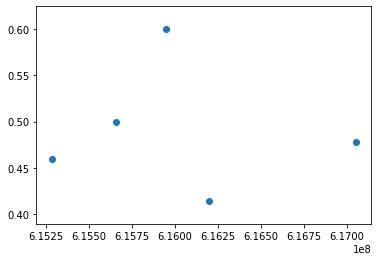

In [44]:
plt.scatter(e3tim,e3r)

# Other Tests


(array([12., 27., 15., 14., 14.,  8., 10., 10.,  2.,  0.]),
 array([ 30, 107, 184, 261, 338, 415, 492, 569, 646, 723, 800]),
 <a list of 1 Patch objects>)

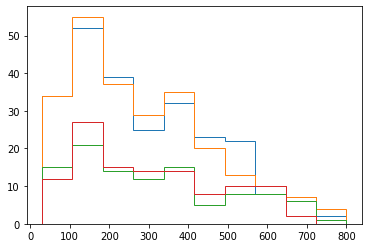

In [45]:
plt.hist(e3['PI'][:248],bins=np.arange(30,877,77),histtype='step')
plt.hist(e3['PI'][248:],bins=np.arange(30,877,77),histtype='step')

plt.hist(e2['PI'][:112],bins=np.arange(30,877,77),histtype='step')
plt.hist(e2['PI'][112:],bins=np.arange(30,877,77),histtype='step')

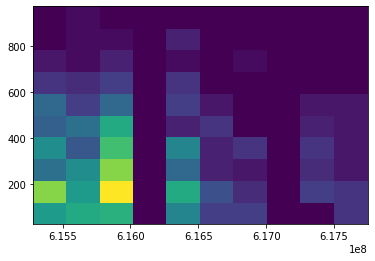

In [46]:
a = plt.hist2d(e3['TIME'],e3['PI'])

In [47]:
#want to normalize each column
a[0][2,:] #third column, starting from bottom

array([21., 33., 27., 23., 20., 11.,  6.,  3.,  1.,  0.])

In [48]:
b = np.zeros((10,10))
for i in range(10):
    med = np.nanmedian(a[0][i,:])
    b[:,i] = a[0][i,:]/med

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Text(0.5, 0, 'Time')

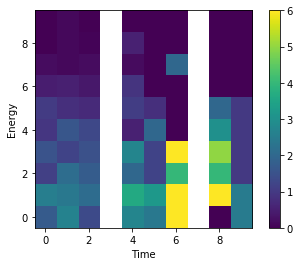

In [49]:
plt.imshow(b,origin='lower',vmax=6)
plt.colorbar()
plt.ylabel('Energy')
plt.xlabel('Time')